In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import warnings
warnings.filterwarnings('ignore')

In [366]:
def plot_predict(model, X_train, y_train, X_test, y_test):
    compare_train = y_train.copy()
    compare_train['Predicted'] = model.predict(X_train)
    MSE_train = mean_squared_error(y_train, compare_train['Predicted'])
    print('MSE for train data: %f' % MSE_train)
    print('Plot for train data:')
    compare_train.plot(figsize=(15,3))
    plt.show()
    # Make prediction on test data:
    compare_test = y_test.copy()
    compare_test['Predicted'] = model.predict(X_test)
    MSE_test = mean_squared_error(y_test, compare_test['Predicted'])
    print('MSE for test data: %f' % MSE_test)
    print('Plot for test data:')
    compare_test.plot(figsize=(15,3))
    plt.show()

## Objectives
- This project's objective is trying to forecast the **relative humidity** based on historical data from 2006 to the present. 
- In this setting, I want apply two approaches to the problem:
   1. The first approach is to use **linear regression** using other weather features such as temperture or wind atmospheric pressure to predict humidity.
   2. The second approach is to apply **univariate time series analysis** that focus only past humidity data.
- After having the 2 analysis, comparison will be performed to access the effectiveness and accuracy.

## Data Loading

In [5]:
# Load the raw data from files:
X_train = pd.read_csv('data/weather_data_train.csv', index_col='datetime',
                     sep=';', decimal=',', infer_datetime_format=True)
X_test = pd.read_csv('data/weather_data_test.csv', index_col='datetime',
                     sep=';', decimal=',', infer_datetime_format=True)
y_train = pd.read_csv('data/weather_data_train_labels.csv', index_col='datetime',
                     sep=';', decimal=',', infer_datetime_format=True)
y_test = pd.read_csv('data/weather_data_test_labels.csv', index_col='datetime',
                     sep=';', decimal=',', infer_datetime_format=True)
# Change the index to datetime format:
new_index_train = pd.to_datetime(X_train.index)
new_index_test = pd.to_datetime(X_test.index)
X_train = X_train.reindex(new_index_train)
X_test = X_test.reindex(new_index_test)
y_train = y_train.reindex(new_index_train)
y_test = y_test.reindex(new_index_test)

## Data Exploration

- Let first take a look at the correlation matrix to see how features correlate to each other.
- From the heatmap for the correlation matrix, we can have some key observations:
    1. (Pressure) Po_mu & P_mu are strongly correlated (corr_coef = 1)
    2. (Pressure) Po_var & P_var are strongly correlated (corr_coef = 1)
    3. (Temperature) T_mu, Tx_mu, Tn_mu, Td_mu are strongly correlated (corr_coef = 0.99)
    4. (Temperature) T_var, Tx_var, Tn_var, Td_var also show some correlation

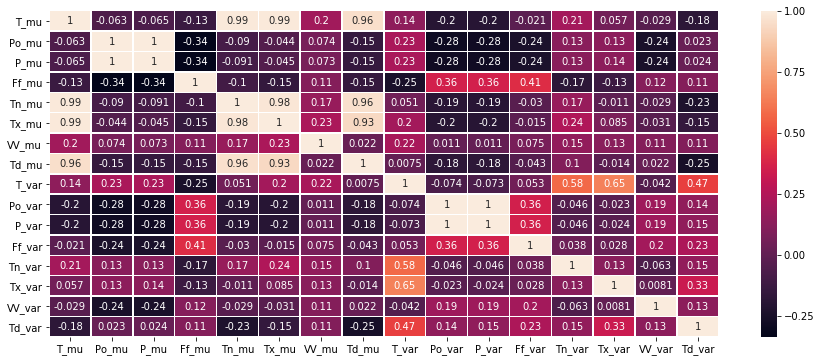

In [62]:
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, ax=ax)

- Above observations leed us to take a look on those features' plots and see how behave.
- From the plot we can see that:
    1. Atmospheric pressure mean and variance at sea level and at weather station are identical, so we can use only one of them for further analysis.
    2. Different temperature means vary together
    3. Mean, max, min temperature variance are higher in summer, while dewpoint temperature variance is higher in winter. They somewhat show seasonal patterns.

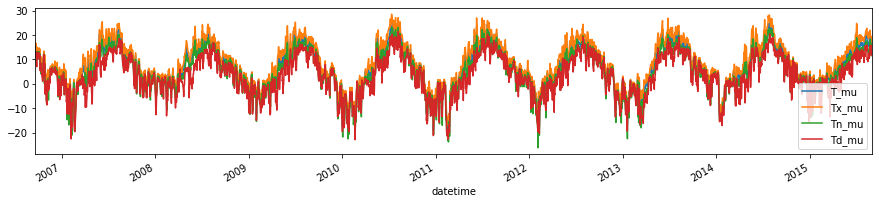

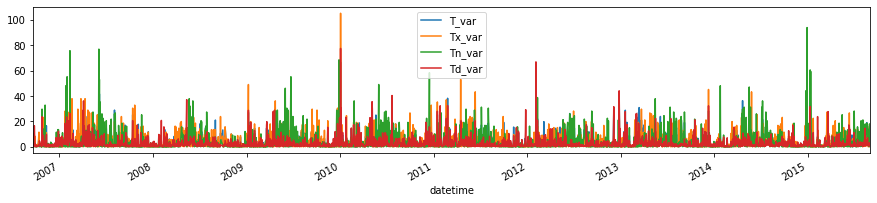

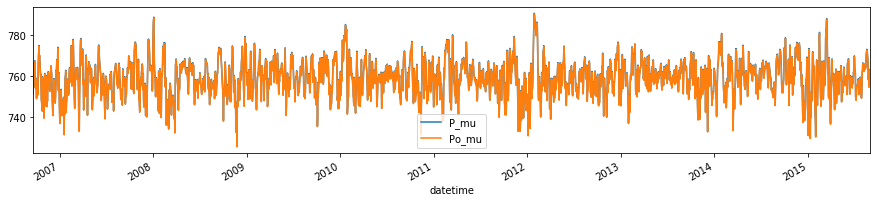

In [63]:
# Temperature plot:
X_train[['T_mu', 'Tx_mu', 'Tn_mu', 'Td_mu']].plot(figsize=(15,3))
X_train[['T_var', 'Tx_var', 'Tn_var', 'Td_var']].plot(figsize=(15,3))
# Pressure plot:
X_train[['P_mu', 'Po_mu']].plot(figsize=(15,3))

# 1st Approach: Linear Regression
- Let first build a linear regression model based on the original data. 
- Before building the model, we first need to standardize the data, as these measurements are not on the same scale. Furthermore, this would prepare us for the later Principle Component Analysis (PCA) because PCA is sensitive to scale.

In [284]:
from sklearn.preprocessing import StandardScaler
# Standardize train data:
X_train_standardized = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_standardized = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
# Extract realtive humidity data (target) and standardize it:
y_train = y_train[['U_mu']]
y_test = y_test[['U_mu']]
y_scaler = StandardScaler().fit(y_train)
y_train_standardized = pd.DataFrame(y_scaler.transform(y_train), columns=y_train.columns, index=y_train.index)
y_test_standardized = pd.DataFrame(y_scaler.transform(y_test), columns=y_test.columns, index=y_test.index)

### Linear regression on original data
- Here we use all of the available data to predict the relative humidity. 
- After training, the result model predicts almost perfect the target both on train and test data, with the mean square error of train data is only 0.013 and test data is 0.017.
- The plots also show that the true values and the predicted values are really closed to each other.

MSE for train data: 0.013078
Plot for train data:


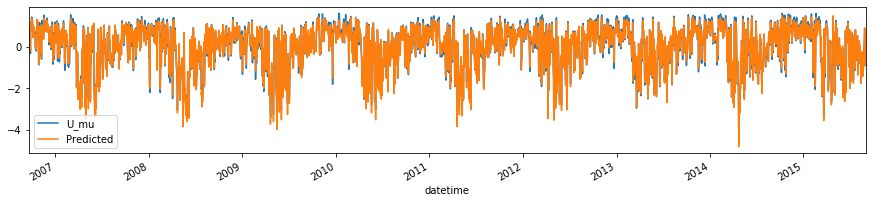

MSE for test data: 0.017169
Plot for test data:


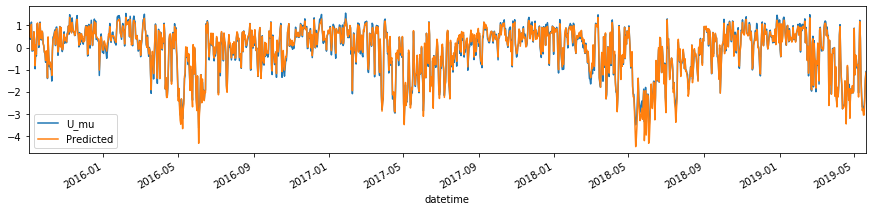

In [367]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Fit a linear regression model to the data:
reg = LinearRegression()
reg.fit(X_train_standardized, y_train_standardized)
# Make prediction on train data:
plot_predict(reg, X_train_standardized, y_train_standardized, X_test_standardized, y_test_standardized)

### Principle Component Analysis
- The above approach predict really well the humidity. However, it use many features to make such prediction. We want to see whether we can perform dimension reduction to simplify our data. Here PCA is used in this task.
- The plot show that with 6 components (on total 16 conponents), we can explain above 80% of the variance. 

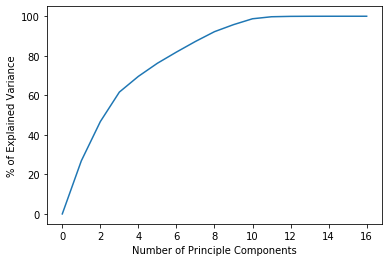

In [299]:
from sklearn.decomposition import PCA
# Get PCA model for visualizing explained variance:
pca_all = PCA()
pca_all.fit(X_train_standardized)
expl_var_ratio = np.insert(pca_all.explained_variance_ratio_, 0, 0)
# Visualize the explained variance:
plt.plot(np.cumsum(expl_var_ratio) * 100)
plt.xlabel('Number of Principle Components')
plt.ylabel('% of Explained Variance')
plt.show()

- Here we want to see how the number of principle components affect the result of regression.
- After fitting several models, we plot the mean square error of each model. 
- We see that with 8 components we already have quite good predition.
- Finally, we have a plot of predicted humidity to compare with the target.

In [344]:
# Perform several regressions against different number of principle components:
X_train_pca = pca.transform(X_train_standardized)
X_test_pca = pca.transform(X_test_standardized)
regs = []
mse_train = []
mse_test = []
for i in range(1, X_train.shape[1]+1):
    reg = LinearRegression()
    reg.fit(X_train_pca[:, :i], y_train_standardized)
    regs.append(reg)
    mse_train.append(mean_squared_error(y_train_standardized['U_mu'], reg.predict(X_train_pca[:, :i])))
    mse_test.append(mean_squared_error(y_test_standardized['U_mu'], reg.predict(X_test_pca[:, :i])))

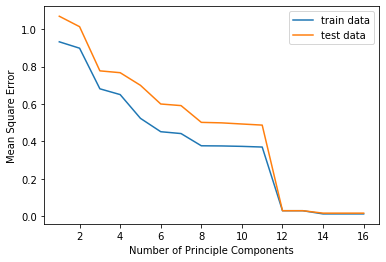

In [345]:
# Visualize the the performance of different models:
plt.plot(range(1, len(mse_train)+1), mse_train, label='train data')
plt.plot(range(1, len(mse_train)+1), mse_test, label='test data')
plt.xlabel('Number of Principle Components')
plt.ylabel('Mean Square Error')
plt.legend()

MSE for train data: 0.376821
Plot for train data:


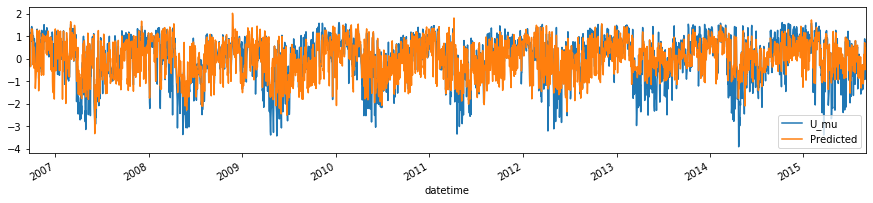

MSE for test data: 0.501811
Plot for test data:


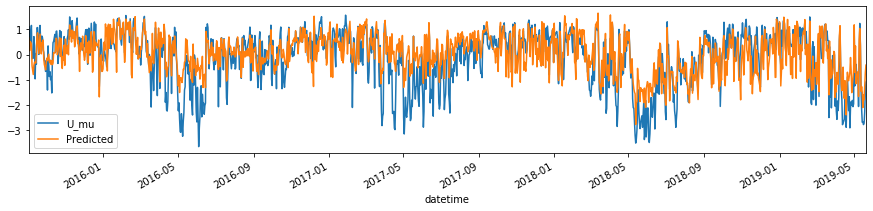

In [369]:
# Choose number of components:
npc = 8
# Make prediction on train data:
plot_predict(regs[npc-1], X_train_pca[:, :npc], y_train_standardized, X_test_pca[:, :npc], y_test_standardized)

# 2nd Approach: Univariate Time Series Analysis

## 1. Data visualiztion

- The first plotting of the data shows some key observations:
    1. No trend in the data
    2. Clear seasonality
    3. Variance seems to be constant
- These observations shows that humidity series is not **stationary** because it exhibits seasonality, meaning that the mean of the series is not constant over time.

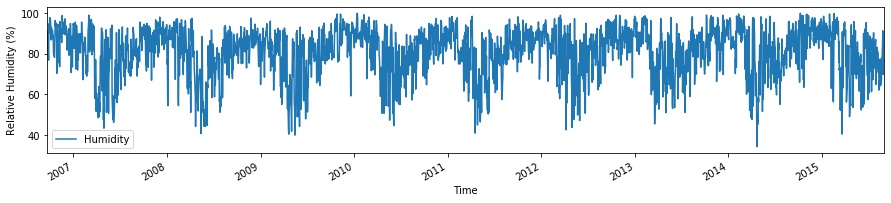

In [6]:
# Extract only the humidity data:
data = y_train[['U_mu']]
data = data.rename(columns={'U_mu': 'Humidity'})
data = data.reindex(pd.to_datetime(data.index))
# First plotting:
ax = data.plot(figsize=(15,3))
ax.set(xlabel='Time', ylabel='Relative Humidity (%)')
plt.show()

- Here we have a boxplot on data grouped by month.
- The plot shows that the variance of the humidity is not constant: humidity in early summer has high variance, while winter has lower and more stable variance.

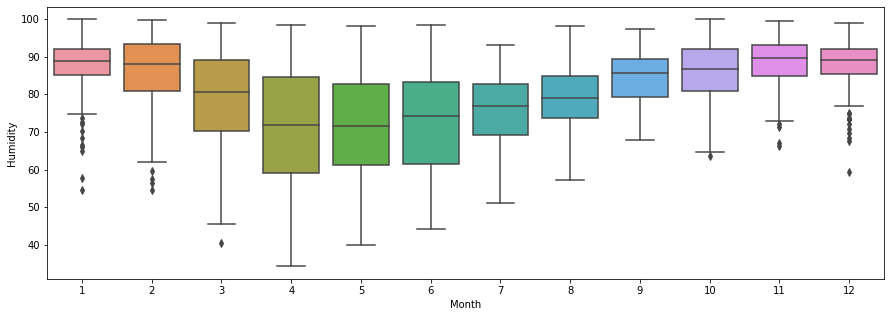

In [7]:
data_box = data[['Humidity']]
data_box['Month'] = data_box.index.month
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=data_box, x='Month', y='Humidity', ax=ax)

- Here is the decomposition of the humidity data to **trend**, **seasonal**, and **residual**.

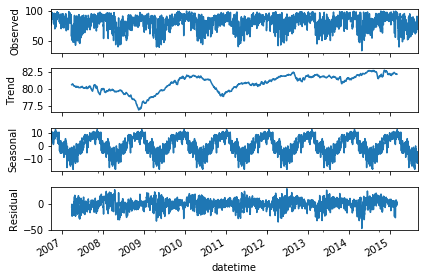

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decom = seasonal_decompose(data, model='additive', freq=365)
ax = decom.plot()

- Here we can use a sine-wave curve to estimate the humidity data

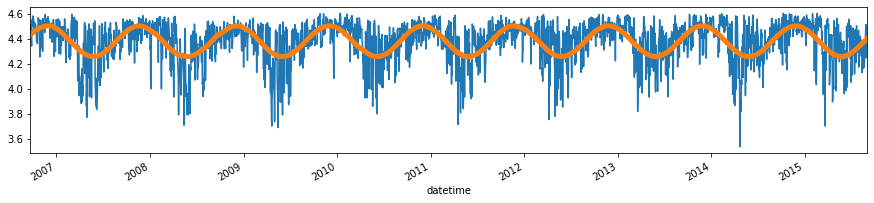

In [471]:
from scipy.optimize import curve_fit

def test(x, a, b, c, d): 
    return a * np.sin(b * x + c) + d

x = range(len(y))
y = data.apply(np.log)['Humidity']
param, param_cov = curve_fit(test, x, y, [1, 0.018, 0, 70])
st = pd.Series(param[0]*(np.sin(param[1]*x + param[2])) + param[3], y.index)

y.plot(figsize=(15,3))
st.plot(figsize=(15,3), linewidth=5)

## 2. Stationarize the series
- In order to analyze a time series, we need to stationarize it. Here we have humidity data which have seasonality, so first we perform differencing with lag 365 to remove seasnonality. 

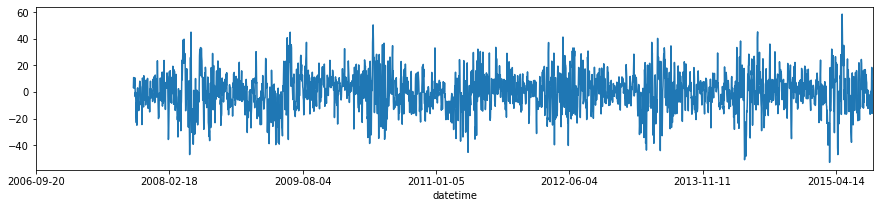

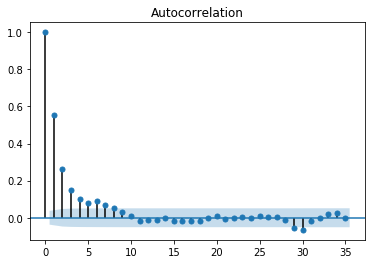

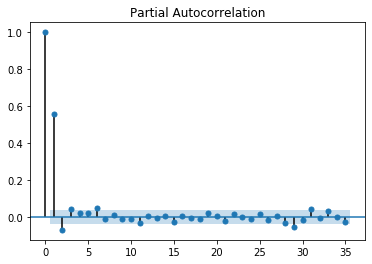

In [29]:
# Perform data differencing with period of 12 months:
data_diff = data.diff(periods=365)
data_diff.plot(figsize=(15,3))
data_diff = data_diff.dropna()
ax1 = plot_acf(data_diff.to_numpy())
ax2 = plot_pacf(data_diff.to_numpy())

## 3. Model Configuration Selection
- After differencing data, we proceed to select parameters for the SARIMA model. 
- The first approach is to plot ACF/PACF to have a sense of how lag of the series vary.
- Next, we consider using package to automatically choose the best configuration for our model.